<a href="https://colab.research.google.com/github/leesa9596/practice/blob/main/predict_stock_market.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

%matplotlib inline
warnings.filterwarnings('ignore')

!pip install finance-datareader

In [ ]:
import FinanceDataReader as fdr

stock_code='AAPL'
stock = fdr.DataReader(stock_code)

In [ ]:
stock.tail(10)

,Close,Open,High,Low,Volume,Change
Date,,,,,,
2021-07-12,144.50,146.22,146.22,144.04,76300000.0,-0.0042
2021-07-13,145.64,143.70,147.46,143.70,100830000.0,0.0079
2021-07-14,149.15,148.00,149.57,147.70,127050000.0,0.0241
2021-07-15,148.48,149.25,149.98,147.10,106820000.0,-0.0045
2021-07-16,146.39,148.46,149.76,145.88,93250000.0,-0.0141
2021-07-19,142.45,143.75,144.07,141.67,121440000.0,-0.0269
2021-07-20,146.15,143.52,147.07,143.00,96350000.0,0.0260
2021-07-21,145.40,145.47,146.12,144.68,74990000.0,-0.0051
2021-07-22,146.80,145.93,148.20,145.81,77340000.0,0.0096


In [ ]:
stock.index

DatetimeIndex(['1980-12-12', '1980-12-15', '1980-12-16', '1980-12-17',
               '1980-12-18', '1980-12-19', '1980-12-22', '1980-12-23',
               '1980-12-24', '1980-12-26',
               ...
               '2021-07-12', '2021-07-13', '2021-07-14', '2021-07-15',
               '2021-07-16', '2021-07-19', '2021-07-20', '2021-07-21',
               '2021-07-22', '2021-07-23'],
              dtype='datetime64[ns]', name='Date', length=10240, freq=None)

In [ ]:
stock['Year'] = stock.index.year
stock['Month'] = stock.index.month
stock['Day'] = stock.index.day

Text(0, 0.5, 'price')

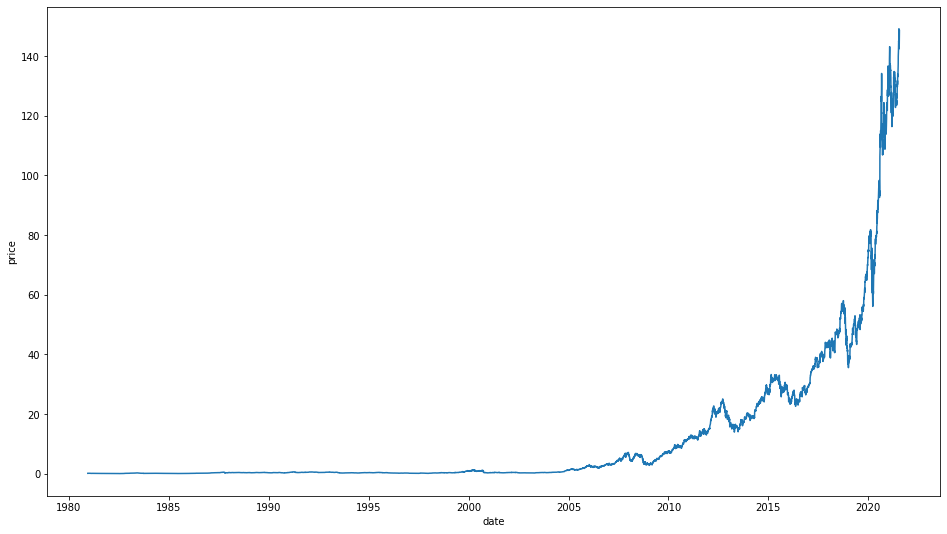

In [ ]:
plt.figure(figsize=(16,9))
sns.lineplot(y=stock['Close'],x=stock.index)
plt.xlabel('date')
plt.ylabel('price')

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler=MinMaxScaler()
scale_cols=['Open','High','Low','Close','Volume']
scaled = scaler.fit_transform(stock[scale_cols])
scaled

array([[5.36193029e-04, 5.33582338e-04, 5.41821876e-04, 5.36552649e-04,
        6.29512116e-02],
       [4.69168901e-04, 4.66884546e-04, 4.74094142e-04, 4.69483568e-04,
        2.34889165e-02],
       [4.02144772e-04, 4.00186754e-04, 4.06366407e-04, 4.02414487e-04,
        1.40456963e-02],
       ...,
       [9.74664879e-01, 9.74254652e-01, 9.79546224e-01, 9.74849095e-01,
        9.90764086e-03],
       [9.77747989e-01, 9.88127793e-01, 9.87199458e-01, 9.84238766e-01,
        1.02239854e-02],
       [9.89477212e-01, 9.91529380e-01, 9.94784964e-01, 9.96042924e-01,
        9.43110488e-03]])

In [ ]:
df=pd.DataFrame(scaled,columns=scale_cols)

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df.drop('Close',1),df['Close'], test_size=0.2, random_state=0, shuffle=False)

In [ ]:
x_test.shape,y_test.shape

((2048, 4), (2048,))

In [ ]:
x_train

,Open,High,Low,Volume
0,0.000536,0.000534,0.000542,0.062951
1,0.000469,0.000467,0.000474,0.023489
2,0.000402,0.000400,0.000406,0.014046
3,0.000469,0.000467,0.000474,0.011449
4,0.000469,0.000467,0.000474,0.009700
...,...,...,...,...
8187,0.106367,0.107917,0.107213,0.047427
8188,0.107976,0.108517,0.108364,0.051545
8189,0.107574,0.107450,0.106671,0.049937
8190,0.108177,0.107917,0.107890,0.039219


In [ ]:
import tensorflow as tf


def windowed_dataset(series, window_size, batch_size, shuffle):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    if shuffle:
        ds = ds.shuffle(1000)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    return ds.batch(batch_size).prefetch(1)

WINDOW_SIZE=20
BATCH_SIZE=32

train_data = windowed_dataset(y_train, WINDOW_SIZE, BATCH_SIZE, True)
test_data = windowed_dataset(y_test, WINDOW_SIZE, BATCH_SIZE, False)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D,Lambda
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


model = Sequential([
                    Conv1D(filters=32,kernel_size=5,
                           padding = "causal",
                           activation= "relu",
                           input_shape=[20,1]),
                  LSTM(16,activation='tanh'),
                  Dense(16,activation='relu'),
                  Dense(1),
])

In [ ]:
loss=Huber()
optimizer =Adam(0.0005)
model.compile(loss=Huber(),optimizer=optimizer,metrics=['mse'])

In [ ]:
earlystopping=EarlyStopping(monitor='val_loss',patience=10)

filename = os.path.join('tmp', 'ckeckpointer.ckpt')
checkpoint = ModelCheckpoint(filename, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss', 
                             verbose=1)

In [ ]:
history = model.fit(train_data, 
                    validation_data=(test_data), 
                    epochs=50, 
                    callbacks=[checkpoint, earlystopping])

Epoch 1/50
256/256 [==============================] - 6s 12ms/step - loss: 5.7945e-06 - mse: 1.1589e-05 - val_loss: 0.0062 - val_mse: 0.0124

Epoch 00001: val_loss improved from inf to 0.00620, saving model to tmp/ckeckpointer.ckpt
Epoch 2/50
256/256 [==============================] - 3s 11ms/step - loss: 1.3720e-06 - mse: 2.7440e-06 - val_loss: 0.0055 - val_mse: 0.0110

Epoch 00002: val_loss improved from 0.00620 to 0.00551, saving model to tmp/ckeckpointer.ckpt
Epoch 3/50
256/256 [==============================] - 3s 11ms/step - loss: 1.2149e-06 - mse: 2.4299e-06 - val_loss: 0.0054 - val_mse: 0.0109

Epoch 00003: val_loss improved from 0.00551 to 0.00543, saving model to tmp/ckeckpointer.ckpt
Epoch 4/50
256/256 [==============================] - 3s 11ms/step - loss: 1.2180e-06 - mse: 2.4359e-06 - val_loss: 0.0053 - val_mse: 0.0105

Epoch 00004: val_loss improved from 0.00543 to 0.00526, saving model to tmp/ckeckpointer.ckpt
Epoch 5/50
256/256 [==============================] - 3s 11m

In [ ]:
model.load_weights(filename)
pred = model.predict(test_data)
pred.shape

(2028, 1)

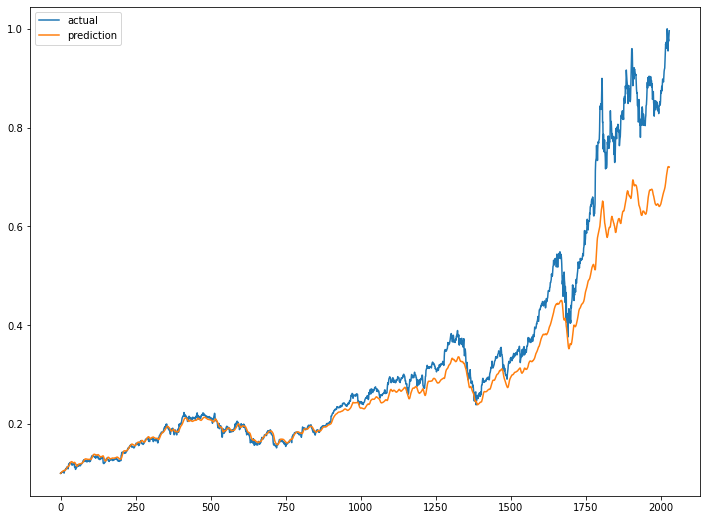

In [ ]:
plt.figure(figsize=(12, 9))
plt.plot(np.asarray(y_test)[20:], label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()